# Handgeschriebene Ziffern

Der beiliegenden Beschreibung der Daten habe ich entnommen, dass es sich um handgeschriebene Ziffern handelt. Die mit 16x16 Bildpunkten abgespeichert sind. Der Beschreibung kann ich weiter entnehmen:

*"The data are in two gzipped files, and each line consists of the digit
id (0-9) followed by the 256 grayscale values."*

Es handelt sich also um eine Textdatei in der in jeder Zeile der Wert der geschriebenen Ziffer sowie die 16x16 = 256 Bildpunkte stehen.

---

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import SGDClassifier

---

In [2]:
def getNumber(data, digit):
    # wähle alle Zeilen in denen die erste Spalte (Spalte mit den Ziffer) mit 'digit' übereinstimmt
    data_number = pd.DataFrame(data[data[0] == digit]) 
    # schneide die erste Spalte weg und gebe den rest zurück
    separated_data = data_number.iloc[:,1:]
    return separated_data


In [3]:
def getNumberImage(data, digit, aggregation):
    # ruft die Hilfsfunktion getNumber auf um alle Bilddaten Daten zu einer Ziffer zu holen
    image_data = getNumber(data, digit)
    # bilde aus allen Bildern zu der einen Ziffer ein aggrigiertes Bild
    if(aggregation == 'median'):
        df1 = pd.DataFrame(image_data.median())
    else:
        df1 = pd.DataFrame(image_data.mean())        
    
    # wandle das format von (1,256) -> (16,16) und gebe diesen transformierten DataFrame zurück
    return df1.values.reshape(16,16)

In [4]:
class Experiment:
    def __init__(self, targets_train, targets_predict):
        self.results_train = pd.DataFrame(targets_train, columns=["targets"])
        self.results_predict = pd.DataFrame(targets_predict, columns=["targets"])

        self.input_data = {}
        
        self.names = []        
        self.configs = []

        
    def get_names(self):
        return self.names
    
    
    def get_results(self):
        return self.results_train, self.results_predict
    
    def get_config_map(self):
        for conf in self.configs:
            print ("CONFIG:", conf['name'], conf['input_data_name'], "\tNum features:", self.input_data[conf['input_data_name']]['data'].shape[1])
    
    
    def add_input_data(self, name, data, description=""):
        self.input_data[name] = {'description': description, 'data': data}
    
    
    def add_config(self, algo, name, input_data_name):
        # TODO: add check for dublicate names
        if input_data_name not in self.input_data:
            print ("ERROR: feature_set_name not found")
            return 
        
        self.names.append(name)
        self.configs.append({ 'name': name, 'algo': algo, 'input_data_name': input_data_name, 'fit': -1})
        

    def _fit(self, conf):
        # get features
        input_data = self.input_data[conf['input_data_name']]['data']

        # fit the features
        print ("Fitting ", conf['name'], "... ")
        
        start = time.time() # startzeit
        conf['fit'] = conf['algo'].fit(input_data, self.results_train['targets'])
        end = time.time() # startzeit
        
        print ("done in ", end - start , "s.")

        
    
    def _predict(self, conf, data, train):
        if data.shape[1] != self.input_data[conf['input_data_name']]['data'].shape[1]:
            print ("ERROR: Number of input features does not match (", conf['name'], ")")
            return
        
        print ("Predicting data with", conf['name'], "... ")
        
        start = time.time() # startzeit
        if train:
            self.results_train[conf['name']] = conf['algo'].predict(data)
        else:
            self.results_predict[conf['name']] = conf['algo'].predict(data)
        end = time.time() # startzeit
        
        print ("done in ", end - start , "s." )
        
    
    def fit(self):
        '''Only trains algorithms if no fit has been calculated before'''
        for conf in self.configs:
            if conf['fit'] == -1:
                self._fit(conf)

                
    def fit_all(self, data):
        '''Trains all algorithms with given data'''
        for conf in self.configs:
            self._fit(conf)

            
    def refit(self, data):
        '''Retrains all algorithms with given data that have been trained before'''
        for conf in self.configs:
            if conf['fit'] != -1:
                self._fit(conf)

                
    def predict(self, name, data, train=False):
        for conf in self.configs:
            if conf['fit'] != -1 and conf['name'] == name:
                self._predict(conf, data, train)
                
    def predict_all(self, data, train=False):
        for conf in self.configs:
            if conf['fit'] != -1:
                self._predict(conf, data, train)

    def predict_proba(self, name, data):
        for conf in self.configs:
            if conf['fit'] != -1 and conf['name'] == name:
                return self._predict_proba(conf, data)

    def _predict_proba(self, conf, data):
        if data.shape[1] != self.input_data[conf['input_data_name']]['data'].shape[1]:
            print ("ERROR: Number of input features does not match (", conf['name'], ")")
            return
        
        print ("Predicting data with", conf['name'], "... ")
        
        start = time.time() # startzeit
        probabilities = conf['algo'].predict_proba(data)
        end = time.time() # startzeit
        
        print ("done in ", end - start , "s." )
        return probabilities

    
    def get_count_df(self, name):
        count_matrix = np.zeros((10,10)) 
        for digit in range(0,10):
            cluster_counts = self.results_train[self.results_train['targets'] == digit].groupby(name).count()['targets']
            for cluster in cluster_counts.keys():
                count_matrix[digit][cluster] = cluster_counts[cluster]
        
        col_names = []
        for i in range(0,10):
            col_names.append("C_" + str(i))
    
        return pd.DataFrame(count_matrix, columns=col_names)

    def get_norm_df(self, name):
        count_df = self.get_count_df(name)
        return count_df.divide(count_df.sum(1), axis=0)
    
    
    def get_all_error_rates(self):
        error_rates = {}
        for conf in self.configs:
            if (conf['fit'] != -1) & (conf['name'] in self.results_train.columns):
                error_rates[conf['name']] = self.get_error_rate(conf['name'])
        return error_rates
                
    def get_error_rate(self, name):
        '''Determine classification error by identifying best fitting column assignment'''
       
            

---

In [5]:
# mit header=None, wird die erste Zeile der Datei nicht als Header interpretiert 
#              (Man könnte den Header in einem solchen Fall als Zeile mit den Spaltenüberschriften bezeichnen)
# mit sep=" ", geben wir an, dass wir das Leerzeichen als Seperator verwenden wollen. 
#              D.h. zwei durch ein Leerzeichen separierte Werte sollen als zwei Werte eingelesen werden.
data_train = pd.read_csv("../data/zip.train", header=None, sep=" ") 

In [6]:
cleaned_train_data = data_train.dropna(axis=1, thresh=2) # lass alle Spalten mit mehr als 2 NaN (Not a Number) vom datensatz fallen 
cleaned_train_data.shape

(7291, 257)

In [7]:
cleaned_train_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
count,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,...,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000
mean,3.903443,-0.996417,-0.981138,-0.951153,-0.887738,-0.773468,-0.610302,-0.368991,-0.045769,-0.052641,...,-0.198547,0.139823,0.116439,-0.314108,-0.653711,-0.837858,-0.922194,-0.957393,-0.979290,-0.994678
std,2.996386,0.051713,0.151202,0.244264,0.360516,0.502659,0.628710,0.716032,0.768304,0.752979,...,0.772895,0.752984,0.757336,0.725859,0.582555,0.414646,0.300830,0.228700,0.158998,0.066056
min,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.999000,-0.950000,...,-1.000000,-0.661500,-0.738000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,4.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.719000,0.061000,0.002000,...,-0.353000,0.368000,0.336000,-0.579000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,7.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.962000,-0.391000,0.254500,0.696000,0.674500,...,0.554000,0.835000,0.815000,0.346000,-0.504500,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
max,9.000000,0.638000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.592000


Aus der Beschreibung der Daten wissen wir, dass es sich um die Ziffern und die dazugehörigen Bilder der Größe 16x16 Pixel handelt. Also in jeder Zeile steht in der 0-ten Spalte die Ziffer und in den folgenden 256 Spalten die einzelnen Pixel der Bilder. Also visualisieren wir diese nun einmal.

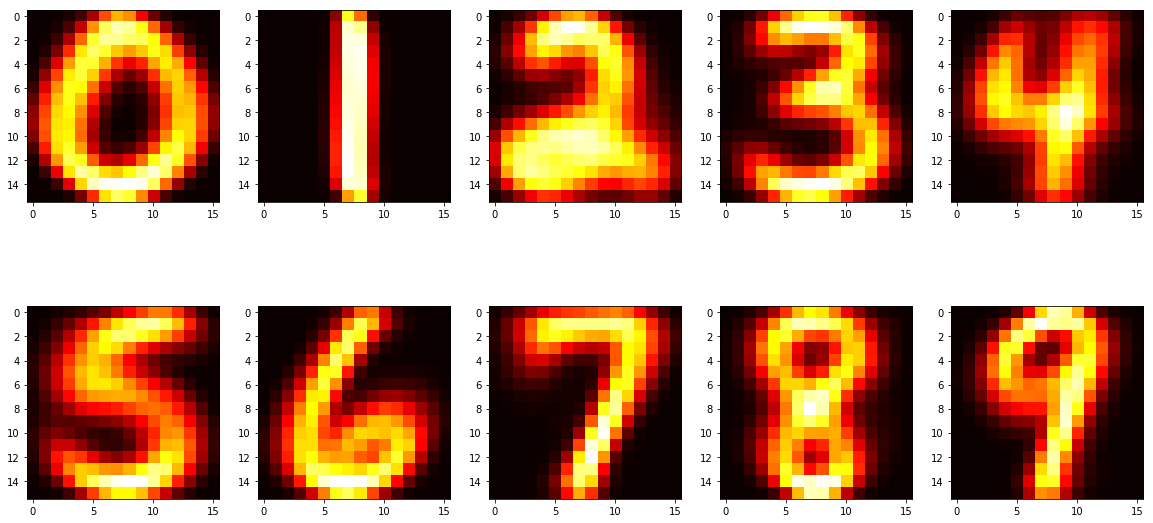

In [8]:
plt.figure(1, figsize=(20, 10))
for i in range(0,10):
    image = getNumberImage(cleaned_train_data,i,'mean')

    # Call signature: subplot(nrows, ncols, index, **kwargs)
    plt.subplot(2,5, 1 + i)
    plt.imshow(image, cmap='hot', interpolation='none')

plt.show()

---

In [9]:
data_test = pd.read_csv("../data/zip.test", header=None, sep=" ") 

In [10]:
cleaned_test_data = data_test.dropna(axis=1, thresh=2) # lass alle Spalten mit mehr als 2 NaN (Not a Number) vom datensatz fallen 
cleaned_test_data.shape

(2007, 257)

In [11]:
cleaned_test_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
count,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,...,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000
mean,3.850523,-0.996595,-0.977925,-0.949133,-0.882643,-0.771821,-0.589944,-0.353905,-0.061801,-0.076219,...,-0.170607,0.133865,0.110366,-0.314661,-0.636191,-0.817464,-0.912635,-0.960662,-0.984057,-0.995801
std,3.018484,0.042205,0.168974,0.245463,0.368629,0.499981,0.646510,0.730745,0.773948,0.764625,...,0.790514,0.760779,0.756387,0.717573,0.592921,0.451498,0.316113,0.220893,0.130031,0.055080
min,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.997000,...,-1.000000,-0.684500,-0.746000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,4.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.714000,0.035000,-0.043000,...,-0.337000,0.333000,0.333000,-0.577000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,6.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.941500,-0.306000,0.308000,0.704500,0.670000,...,0.641500,0.853000,0.805000,0.335000,-0.435500,-0.999000,-1.000000,-1.000000,-1.000000,-1.000000
max,9.000000,-0.130000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.992000,0.563000


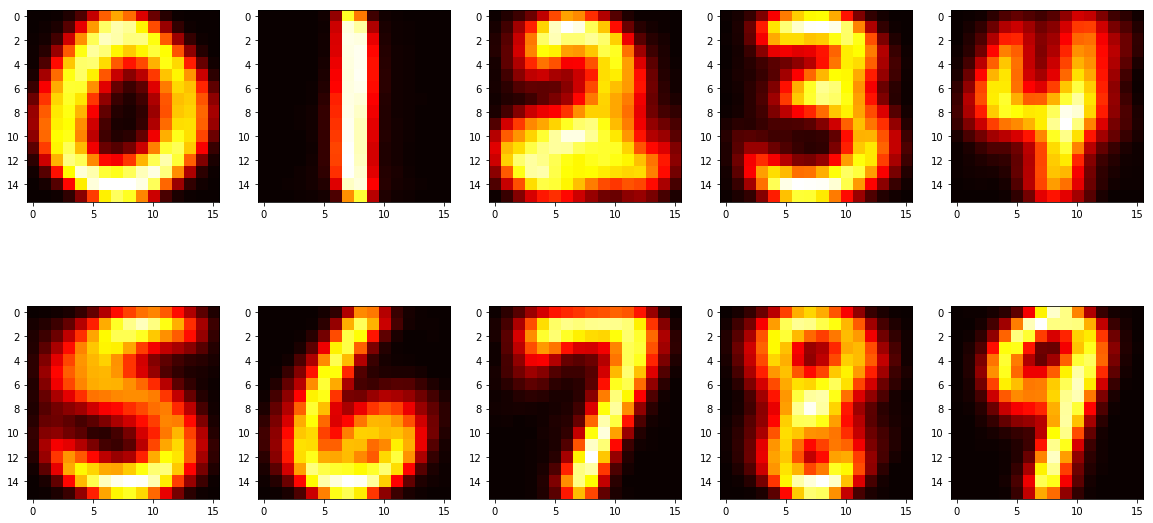

In [12]:
plt.figure(1, figsize=(20, 10))
for i in range(0,10):
    image = getNumberImage(cleaned_test_data,i,'mean')

    # Call signature: subplot(nrows, ncols, index, **kwargs)
    plt.subplot(2,5, 1 + i)
    plt.imshow(image, cmap='hot', interpolation='none')

plt.show()

---

## Split data in train und test

In [13]:
# train data
input_data = cleaned_train_data.iloc[:,1:].values
input_data.shape

(7291, 256)

In [14]:
# test data
test_data = cleaned_test_data.iloc[:,1:].values
test_data.shape

(2007, 256)

In [15]:
# Set targets
exp = Experiment(cleaned_train_data[0].values, cleaned_test_data[0].values)

### Build features

In [16]:
def multires(data):
    num_samples = data.shape[0]
    reshaped_input = data.reshape(num_samples,16,16)
    new_feature_collection = data.mean(1).reshape((-1,1))
    
    for res in [2,4,8]:
        pixel = res
        pixel_size = int(16 / pixel)
        new_features = np.zeros((num_samples, pixel * pixel))
        for k in range(reshaped_input.shape[0]):
            for i in range(0,pixel):
                for j in range(0,pixel):
                    new_features[k,i*pixel + j] = reshaped_input[k,(i*pixel_size):(i+1) * pixel_size,(j*pixel_size):(j+1) * pixel_size].mean()
        new_feature_collection  = np.append(new_feature_collection, new_features, axis=1)
    
    return new_feature_collection

In [17]:
# input featurs are the individual pixels of the image - without transformation
exp.add_input_data('256_pixel', input_data)

In [18]:
# input featurs are lower resolution variants of the images
new_feature_collection = multires(input_data)
exp.add_input_data('res_vari', new_feature_collection)

In [19]:
exp.add_input_data('256_and_res_vari', np.append(input_data, new_feature_collection, axis=1))

-----

## Classification with logistic regression

In [20]:
exp.add_config(LogisticRegression(n_jobs=1, C=10000.0), 'LogReg_1', '256_pixel')
exp.add_config(LogisticRegression(n_jobs=1, C=10000.0), 'LogReg_1_res', 'res_vari')
exp.add_config(LogisticRegression(n_jobs=1, C=10000.0), 'LogReg_1_all', '256_and_res_vari')

exp.add_config(LogisticRegression(n_jobs=1, penalty='l1'), 'LogReg_1_l1', '256_pixel')
exp.add_config(LogisticRegression(n_jobs=1, penalty='l1'), 'LogReg_1_res_l1', 'res_vari')
exp.add_config(LogisticRegression(n_jobs=1, penalty='l1'), 'LogReg_1_all_l1', '256_and_res_vari')

exp.add_config(LogisticRegression(n_jobs=1, penalty='l2'), 'LogReg_1_l2', '256_pixel')
exp.add_config(LogisticRegression(n_jobs=1, penalty='l2'), 'LogReg_1_res_l2', 'res_vari')
exp.add_config(LogisticRegression(n_jobs=1, penalty='l2'), 'LogReg_1_all_l2', '256_and_res_vari')

exp.add_config(SGDClassifier(n_jobs=1, penalty='l2'), 'SGDLogReg_1_l2', '256_pixel')
exp.add_config(SGDClassifier(n_jobs=1, penalty='l2'), 'SGDLogReg_1_res_l2', 'res_vari')
exp.add_config(SGDClassifier(n_jobs=1, penalty='l2'), 'SGDLogReg_1_all_l2', '256_and_res_vari')

## Training

In [21]:
print(exp.get_names())
print(exp.get_config_map())

['LogReg_1', 'LogReg_1_res', 'LogReg_1_all', 'LogReg_1_l1', 'LogReg_1_res_l1', 'LogReg_1_all_l1', 'LogReg_1_l2', 'LogReg_1_res_l2', 'LogReg_1_all_l2', 'SGDLogReg_1_l2', 'SGDLogReg_1_res_l2', 'SGDLogReg_1_all_l2']
CONFIG: LogReg_1 256_pixel 	Num features: 256
CONFIG: LogReg_1_res res_vari 	Num features: 85
CONFIG: LogReg_1_all 256_and_res_vari 	Num features: 341
CONFIG: LogReg_1_l1 256_pixel 	Num features: 256
CONFIG: LogReg_1_res_l1 res_vari 	Num features: 85
CONFIG: LogReg_1_all_l1 256_and_res_vari 	Num features: 341
CONFIG: LogReg_1_l2 256_pixel 	Num features: 256
CONFIG: LogReg_1_res_l2 res_vari 	Num features: 85
CONFIG: LogReg_1_all_l2 256_and_res_vari 	Num features: 341
CONFIG: SGDLogReg_1_l2 256_pixel 	Num features: 256
CONFIG: SGDLogReg_1_res_l2 res_vari 	Num features: 85
CONFIG: SGDLogReg_1_all_l2 256_and_res_vari 	Num features: 341
None


In [22]:
exp.fit()

Fitting  LogReg_1 ... 
done in  83.1544840335846 s.
Fitting  LogReg_1_res ... 
done in  7.032793045043945 s.
Fitting  LogReg_1_all ... 
done in  121.78565311431885 s.
Fitting  LogReg_1_l1 ... 
done in  16.964927196502686 s.
Fitting  LogReg_1_res_l1 ... 
done in  8.997125148773193 s.
Fitting  LogReg_1_all_l1 ... 
done in  16.290098190307617 s.
Fitting  LogReg_1_l2 ... 
done in  6.8100409507751465 s.
Fitting  LogReg_1_res_l2 ... 
done in  2.020390748977661 s.
Fitting  LogReg_1_all_l2 ... 
done in  8.851219892501831 s.
Fitting  SGDLogReg_1_l2 ... 
done in  0.15837788581848145 s.
Fitting  SGDLogReg_1_res_l2 ... 


/Users/maddosz/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


done in  0.06827902793884277 s.
Fitting  SGDLogReg_1_all_l2 ... 
done in  0.17962193489074707 s.


## Vorhersage und Fehler der Verfahren auf dem Test set

In [23]:
test_data_res = multires(test_data)
test_data_all = np.append(test_data, test_data_res, axis=1)

In [24]:
exp.predict('LogReg_1',test_data)
exp.predict('LogReg_1_res',test_data_res)
exp.predict('LogReg_1_all',test_data_all)

Predicting data with LogReg_1 ... 
done in  0.00646209716796875 s.
Predicting data with LogReg_1_res ... 
done in  0.0013630390167236328 s.
Predicting data with LogReg_1_all ... 
done in  0.0022246837615966797 s.


In [25]:
exp.predict('LogReg_1_l1',test_data)
exp.predict('LogReg_1_res_l1',test_data_res)
exp.predict('LogReg_1_all_l1',test_data_all)



Predicting data with LogReg_1_l1 ... 
done in  0.0031991004943847656 s.
Predicting data with LogReg_1_res_l1 ... 
done in  0.0018320083618164062 s.
Predicting data with LogReg_1_all_l1 ... 
done in  0.003351926803588867 s.


In [26]:

exp.predict('LogReg_1_l2',test_data)
exp.predict('LogReg_1_res_l2',test_data_res)
exp.predict('LogReg_1_all_l2',test_data_all)

Predicting data with LogReg_1_l2 ... 
done in  0.0031447410583496094 s.
Predicting data with LogReg_1_res_l2 ... 
done in  0.0017931461334228516 s.
Predicting data with LogReg_1_all_l2 ... 
done in  0.0025310516357421875 s.


In [27]:
exp.predict('SGDLogReg_1_l2',test_data)
exp.predict('SGDLogReg_1_res_l2',test_data_res)
exp.predict('SGDLogReg_1_all_l2',test_data_all)

Predicting data with SGDLogReg_1_l2 ... 
done in  0.0030319690704345703 s.
Predicting data with SGDLogReg_1_res_l2 ... 
done in  0.0014061927795410156 s.
Predicting data with SGDLogReg_1_all_l2 ... 
done in  0.0022878646850585938 s.


In [28]:
results_train, results_test = exp.get_results()
results_train.head()

,targets
0,6.0
1,5.0
2,4.0
3,7.0
4,3.0


In [29]:
results_test.head()

,targets,LogReg_1,LogReg_1_res,LogReg_1_all,LogReg_1_l1,LogReg_1_res_l1,LogReg_1_all_l1,LogReg_1_l2,LogReg_1_res_l2,LogReg_1_all_l2,SGDLogReg_1_l2,SGDLogReg_1_res_l2,SGDLogReg_1_all_l2
0,9,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0
1,6,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
2,3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
3,6,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
4,6,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0


In [30]:
print("LogReg_1:",1.0*(results_test['targets'] == results_test['LogReg_1']).sum()/results_test['targets'].count())
print("LogReg_res:",1.0*(results_test['targets'] == results_test['LogReg_1_res']).sum()/results_test['targets'].count())
print("LogReg_all:",1.0*(results_test['targets'] == results_test['LogReg_1_all']).sum()/results_test['targets'].count())

LogReg_1: 0.8898854010961634
LogReg_res: 0.9142999501743896
LogReg_all: 0.8913801694070752


In [31]:
print("LogReg_1:",1.0*(results_test['targets'] == results_test['LogReg_1_l1']).sum()/results_test['targets'].count())
print("LogReg_res:",1.0*(results_test['targets'] == results_test['LogReg_1_res_l1']).sum()/results_test['targets'].count())
print("LogReg_all:",1.0*(results_test['targets'] == results_test['LogReg_1_all_l1']).sum()/results_test['targets'].count())

LogReg_1: 0.9138016940707524
LogReg_res: 0.9157947184853015
LogReg_all: 0.9138016940707524


In [32]:
print("LogReg_1:",1.0*(results_test['targets'] == results_test['LogReg_1_l2']).sum()/results_test['targets'].count())
print("LogReg_res:",1.0*(results_test['targets'] == results_test['LogReg_1_res_l2']).sum()/results_test['targets'].count())
print("LogReg_all:",1.0*(results_test['targets'] == results_test['LogReg_1_all_l2']).sum()/results_test['targets'].count())

LogReg_1: 0.911310413552566
LogReg_res: 0.9172894867962132
LogReg_all: 0.9118086696562033


In [33]:
print("SGDLogReg_1:",1.0*(results_test['targets']   == results_test['SGDLogReg_1_l2']).sum()/results_test['targets'].count())
print("SGDLogReg_res:",1.0*(results_test['targets'] == results_test['SGDLogReg_1_res_l2']).sum()/results_test['targets'].count())
print("SGDLogReg_all:",1.0*(results_test['targets'] == results_test['SGDLogReg_1_all_l2']).sum()/results_test['targets'].count())

SGDLogReg_1: 0.8973592426507224
SGDLogReg_res: 0.8963627304434479
SGDLogReg_all: 0.8784255107125062


## ROC und AUC

In [34]:
proba_test = exp.predict_proba('LogReg_1_res', test_data_res)

Predicting data with LogReg_1_res ... 
done in  0.004936933517456055 s.


In [35]:
import sklearn.metrics as metrics

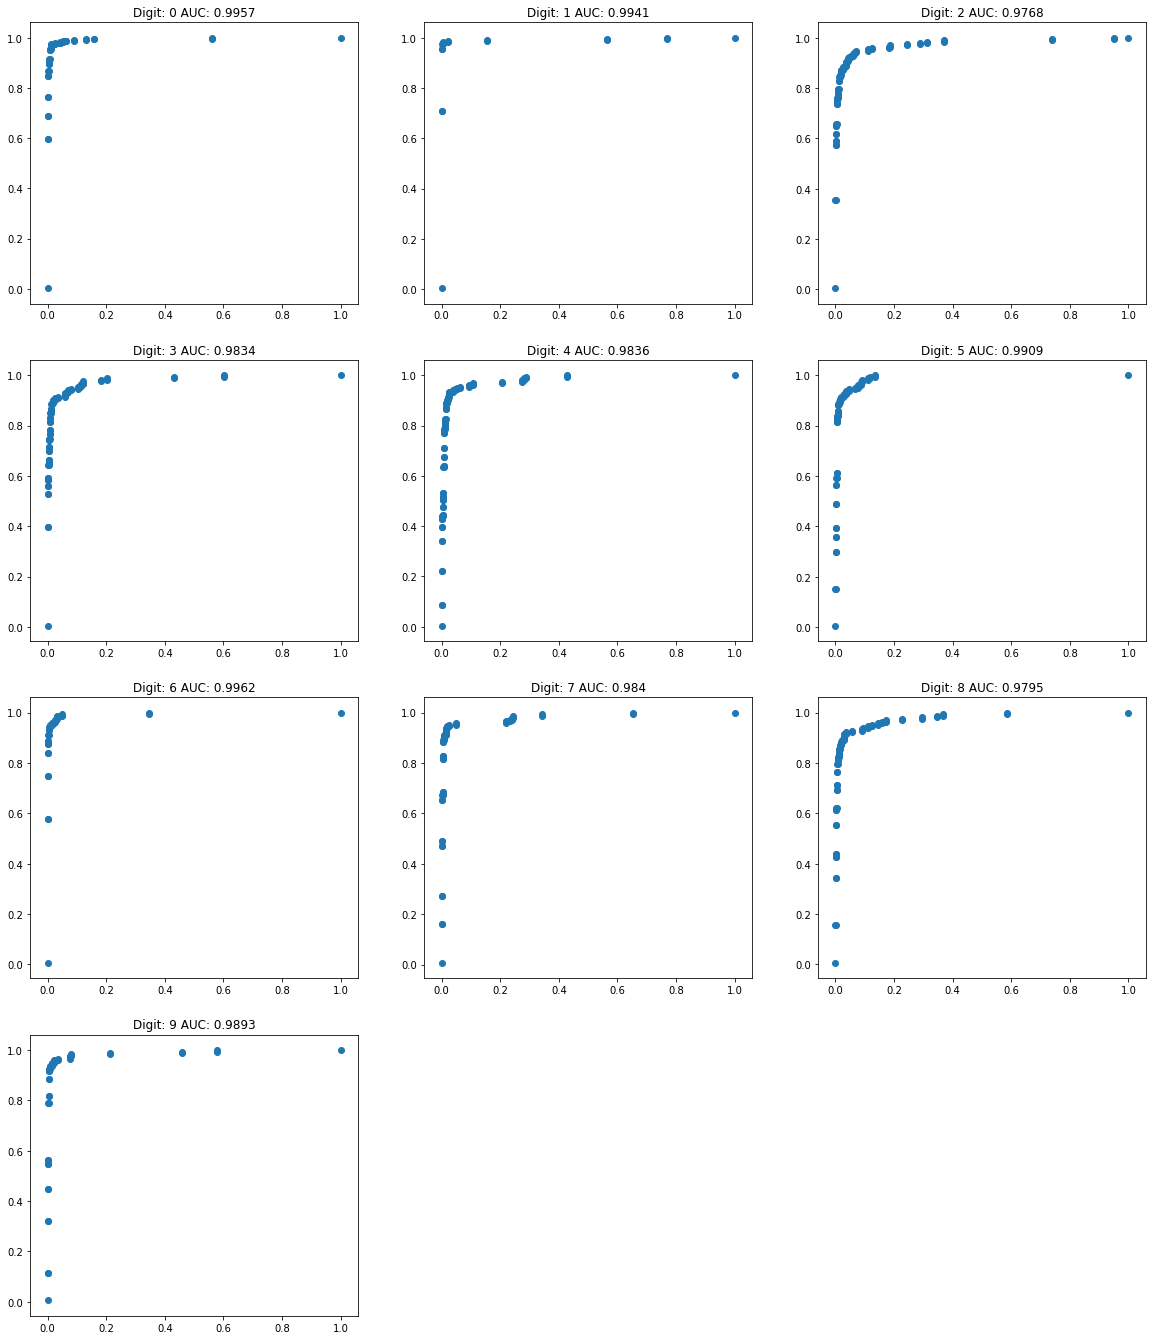

In [36]:
plt.figure(1, figsize=(20,30))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

for i in range(0,10):
    fpr, tpr, thresholds = metrics.roc_curve(results_test['targets'], proba_test[:,i], pos_label=i)
    auc = metrics.auc(fpr, tpr)
    ax = plt.subplot(5,3, 1 + i)
    ax.scatter(fpr, tpr)
    ax.set_title('Digit: ' + str(i) + ' AUC: ' + str(round(auc,4)))
    

plt.show()